Note: Throughout this notebook, you are **not obliged to** fill any function. Provided function headers or codes aim to help you to find a way to the solution. You are free to delete them if that helps.

# Question: Linear Regression

Suppose we are given the following model 
$$
y_i \approx m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{i=1}^K b_k \cos(\omega_k x_i)
$$

Show that this problem can be reduced to a least squares problem of form
$$
y \approx A(\omega, K) \theta
$$
where the design matrix $A(\omega, K)$ is determined solely by the frquency parameters $\omega$ and the remaining parameters can be organized as a vector $\theta = (m, a_{1:K}, b_{1:K})$. 


In [332]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd


## Write a program that generates data from the above model

In [333]:
# This data is generated for K=4,N=50,m=0.2. It is distorted with a noise as well. You may try to obtain a similar plot or
# generate a different one.
N=50; K=4; m = np.array([0.2]).reshape(1,1)

x = (np.random.rand(N)*2-1).reshape(N,1)
# Select a and b coefficients
a = (np.random.rand(K)*2-1).reshape(K,1)
b = (np.random.rand(K)*2-1).reshape(K,1)
om_true = np.array([0,np.pi/2,np.pi,np.pi*3/2]).reshape(K,1)
noise = np.random.normal(0, 0.5, N).reshape(N,1)

# Create design matrix
A = np.zeros((N,K*2+1))
for i in x:
    sin = np.sin(np.dot(om_true,i))
    cos = np.cos(np.dot(om_true,i))
    A[np.where(x == i)[0]] = i
    A[np.where(x == i)[0],1:(K+1)] = sin
    A[np.where(x == i)[0],(K+1):(K*2+1)] = cos
# Create parameter vector
theta = np.vstack((np.vstack((m,a)),b))
y = np.dot(A,theta) + noise

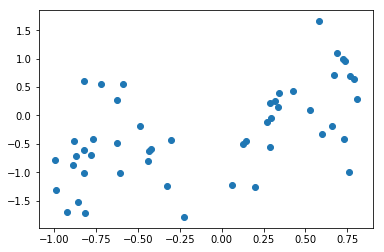

In [334]:
plt.scatter(x,y)

## For a given set of frequency parameters $\omega$ solve the problem using least squares

In this experiment, we will assume that we know the frequency parameters $\omega$ (hence also the dimension $K$). Write a program to find the least squares solution of $\theta$.

Error sum is 
$$\sum_{i=1}^{N}[y_i - A_i\theta]^2$$

$$\theta^* = (A^TA)^{-1}A^Ty$$

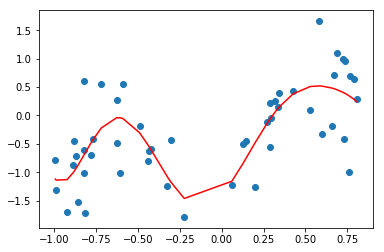

In [335]:
#%matplotlib inline
# Setup the vandermonde matrix
N = len(x)
def make_design_matrix(x, om):
    # Fill this method
    N = len(x)
    K = len(om)
    A = np.hstack((np.hstack((x,np.sin(np.dot(x,om.T)))),np.cos(np.dot(x,om.T))))
    return A

A = make_design_matrix(x.reshape(N,1), om_true)
theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A),A)),np.transpose(A)),y)
data = pd.DataFrame(np.hstack((x,np.dot(A,theta))))
data = data.sort_values(by=[0])

plt.scatter(x,y)
plt.plot(data[0],data[1], color= 'red')

## Evaluate and visualize the error as a function of $\omega$ only

This error can be fully visualized for $K=1$ and $K=2$.

Note that for any given $\omega$ we could run the least squares algorithm to find the best $m, \alpha, \beta$ parameters. We will denote the optimal parameters as $\theta^*(\omega) = (m, a, b)^*$. We will exhaustively evaluate the error for all $\omega$ by computing $E(\omega, \theta^*(\omega))$.

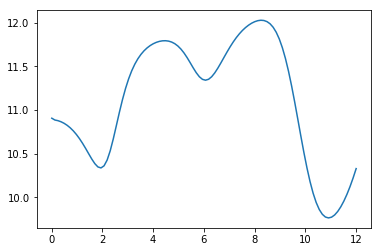

In [336]:
#%matplotlib inline
# Generate different omegas and compute error for each of them.
OM = np.linspace(0.01,12,100)
EE = []

for i in OM:
    A = make_design_matrix(x,np.array(i).reshape(1,1))
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A),A)),np.transpose(A)),y)
    e = y - np.dot(A,theta).reshape(len(y),1)
    et = np.transpose(e)
    EE.append(np.dot(et,e)[0]/2)

plt.plot(OM, EE)

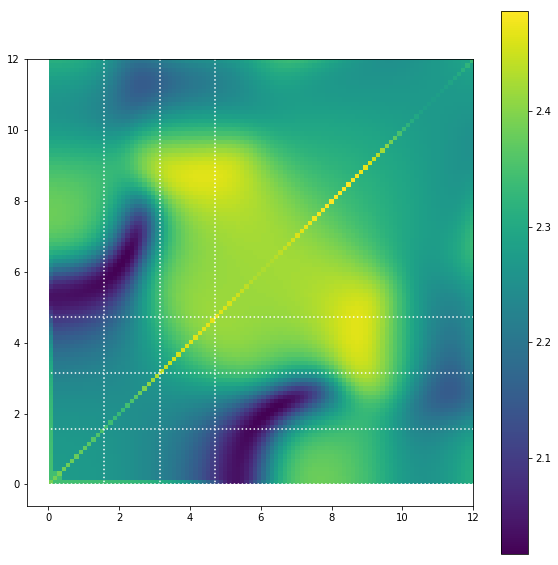

In [337]:
#%matplotlib inline

OM = np.linspace(0.01,12,100)
EE = np.zeros((len(OM),len(OM)))

for i,omega1 in enumerate(OM):
    for j,omega2 in enumerate(OM):
        # Compute the errors for different omega combinations. Do not forget to consider rank defficient design matrix case.
        om_tuple = np.array([omega1, omega2]).reshape(2,1)
        A = make_design_matrix(x,om_tuple)
        theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A),A)),np.transpose(A)),y)
        e = y - np.dot(A,theta).reshape(len(y),1)
        et = np.transpose(e)
        EE[i][j]=(np.dot(et,e)[0]/2)

# These lines are for plotting purposes
l = min(OM)
r = max(OM)
plt.figure(figsize=(10,10))
plt.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
for o in om_true:
    plt.axvline(o, color='w',ls=':')
    plt.axhline(o, color='w',ls=':')
    

plt.colorbar()
plt.show()

# Question: Stochastic Gradient Descent

For the sinusoidal model, develop a SGD method for estimating $\omega$ as well as the other parameters.

## Derive and implement the expression of the gradient

$$
E_i(m,a,b,\omega) = \frac{1}{2}\left(y_i - \left(m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{k=1}^K b_k \cos(\omega_k x_i)\right)\right)^2
$$

$$
e_i = y_i - \left(m x_i + \sum_{k=1}^K a_k \sin(\omega_k x_i) + \sum_{k=1}^K b_k \cos(\omega_k x_i)\right)
$$

\begin{eqnarray}
\nabla E_i = \left(\begin{array}{c} \frac{\partial E_i}{\partial m} \\ \frac{\partial E_i}{\partial a_1} \\
\vdots \\ \frac{\partial E_i}{\partial a_K} \\  \frac{\partial E_i}{\partial b_1} \\
\vdots \\ \frac{\partial E_i}{\partial b_K} \\  \frac{\partial E_i}{\partial \omega_1} \\
\vdots \\ \frac{\partial E_i}{\partial \omega_K} 
\end{array}
\right) = 
-e_i \left(\begin{array}{c} x_i \\ \sin(\omega_1 x_i) \\ \vdots \\ \sin(\omega_K x_i) \\ 
\cos(\omega_1 x_i) \\ \vdots \\ \cos(\omega_K x_i) \\ a_1 \cos(\omega_k x_i) x_i - b_1 \sin(\omega_1 x_i) x_i \\
\vdots \\ a_K \cos(\omega_K x_i) x_i - b_K \sin(\omega_K x_i) x_i\end{array}
\right)
\end{eqnarray}

In [338]:
# You can fill this function to genrerate the actual model.
def model_fun(x, theta, omega):
    A = make_design_matrix(x, omega)
    return np.dot(A, theta) , A

# You can fill this funtion to compute gradients of the parameters
def grad_fun(y, x, theta, omega, e):
    K = len(omega) 
    N = len(x)
    gm = x.reshape(N,1)
    ga = np.sin(np.dot(x,omega.T))
    gb = np.cos(np.dot(x,omega.T))
    gom = np.multiply(np.cos(np.dot(x,omega.T)),theta.T[0,1:K+1]) - np.multiply(np.sin(np.dot(x,omega.T)),theta.T[0,K+1:2*K+1])
    grad = np.multiply((-1)*e,np.hstack((np.hstack((np.hstack((gm,ga)),gb)),gom)))
    return grad

## Implement SGD

Implement SGD and test it on synthetic data generated in Question 1. 
Show the evolution of the error as a function of iterations.


In [339]:
#%matplotlib inline
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
K_try = 2
ep = 0.01
om = np.array(np.random.rand(K_try)*4*np.pi).reshape(K_try,1)
th = np.array(np.random.randn(K_try*2+1)).reshape(K_try*2+1,1)

def iterateSGD(B, MAX_EPOCH, om, th, plot):
    K_try = 2
    # Initialize
    ERR = []
    OM_PATH = []
    TH_PATH = []
    
    OM_PATH.append(om)
    TH_PATH.append(th)
    for epoch in range(MAX_EPOCH):
        # Implement SGD here
        randindex = np.random.randint(N, size=B)
        y_mini = y[randindex]
        x_mini = x[randindex]
        y_hat, A = model_fun(x_mini,th,om)
        e = y_mini - y_hat
        grad = grad_fun(y_mini, x_mini, th, om, e)
        Esq = np.dot(e.T,e)/2
        th = th - ep*np.mean(grad[:,0:K_try*2+1], axis=0).reshape(K_try*2+1,1)
        om = om - ep*np.mean(grad[:,K_try*2+1:K_try*3+1], axis=0).reshape(K_try,1)
        OM_PATH.append(om)
        TH_PATH.append(th)
        ERR.append(Esq[0,0])
    if plot == 1:
        #print("ERR ", ERR)
        # PLot the error as a function of iteratation
        plt.figure(figsize=(10,3))
        plt.xlabel("epoch")
        plt.ylabel("SE")
        plt.plot(ERR)
        plt.show()
    else:
        return om,th,np.array(OM_PATH),np.array(TH_PATH)

om_opt, th_opt, OM_PATH, TH_PATH = iterateSGD(10,5000,om,th,0)
interact(iterateSGD, B=(0,50,1) , MAX_EPOCH=(100, 10000, 100), om=fixed(om), th=fixed(th), plot=fixed(1))

interactive(children=(IntSlider(value=25, description='B', max=50), IntSlider(value=5000, description='MAX_EPOCH', max=10000, min=100, step=100), Output()), _dom_classes=('widget-interact',))

<function __main__.iterateSGD>

## Plot the true function and the fit

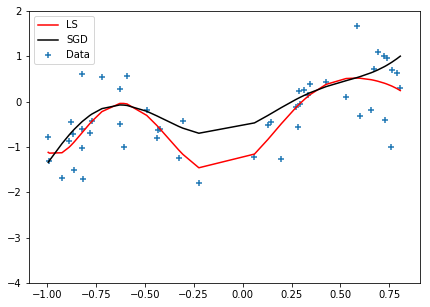

In [340]:
#%matplotlib inline
# Plot data, LS and SGD at once 
def plot_ls_sgd(ax, om_sgd, OM):
    ax.scatter(x,y, marker='+', label = 'Data')
    A_ls = make_design_matrix(x, OM.reshape(len(OM),1))
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(np.transpose(A_ls),A_ls)),np.transpose(A_ls)),y)
    data = pd.DataFrame(np.hstack((x,np.dot(A_ls,theta))))
    data = data.sort_values(by=[0])
    plt.plot(data[0],data[1], color= 'red', label='LS')
    th_sgd=np.zeros(om_sgd.shape)
    for i in range(len(OM_PATH)):
        if np.array_equal(OM_PATH[i],om_sgd):
            ix = i
            th_sgd = TH_PATH[ix]
    th_sgd = TH_PATH[np.where(OM_PATH==om_sgd)[0][0]]
    A_sgd = make_design_matrix(x, om_sgd)
    data = pd.DataFrame(np.hstack((x,np.dot(A_sgd,th_sgd))))
    data = data.sort_values(by=[0])
    ax.plot(data[0],data[1], color= 'black', label='SGD')
    ax.set_ylim(-4,2)
    ax.legend()
    
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
plot_ls_sgd(ax1, om_opt, om_true)

## Plot the error surface and plot the path taken by SGD

<IPython.core.display.Javascript object>


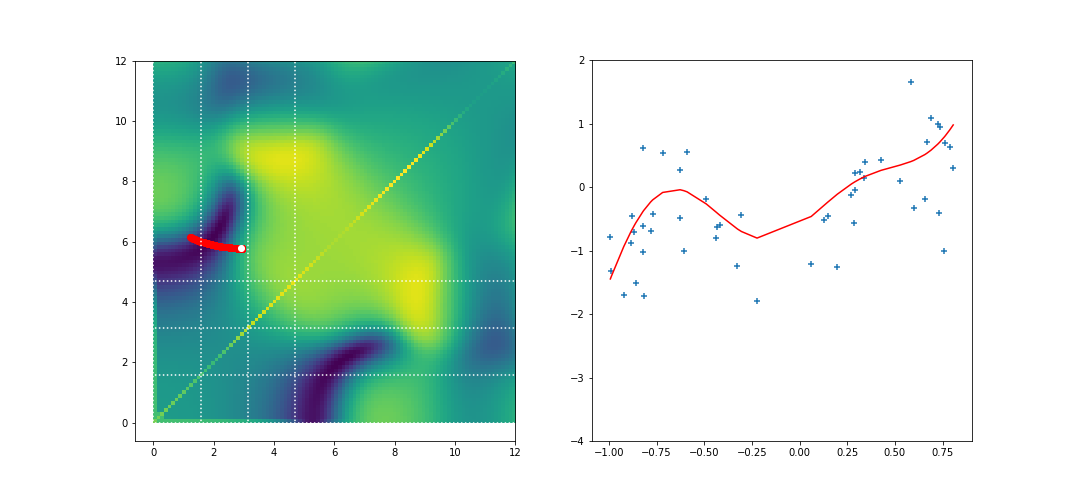

In [348]:
%matplotlib notebook

# These lines are for plotting purposes
l = min(OM)
r = max(OM)
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax1.imshow(np.log(EE), extent=(l,r,l,r), interpolation='nearest', origin='lower')
for o in om_true:
    plt.axvline(o, color='w',ls=':')
    plt.axhline(o, color='w',ls=':')

ax1.scatter(OM_PATH[:-1,0,:], OM_PATH[:-1,1,:], color='red')
ax1.scatter(OM_PATH[-1,0,:], OM_PATH[-1,1,:], color='white')

def onclick(event):
    ax2 = fig.add_subplot(122)
    ax2.cla()
    ax2.set_ylim(-4,2)
    om_current = np.array([[event.xdata],[event.ydata]])
    plot_ls_sgd(ax2, om_current, om_current)
    #plt.scatter(x,y, marker='+', label = 'Data')
    fig.canvas.draw()
    
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [342]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd

from sklearn.datasets import load_iris

# Question 3: Decision Trees

In this exercise we will investigate and compare two alternative measures for choosing a 
decision boundary and a feature in decision trees: (a) Gini impurity and (b) Information Gain. 

Suppose there are $C$ classes in a dataset with $N$ samples. The number of examples having class $c$ is
$N_c$ where $\sum_c N_c = N$. 

At each step, a decision tree algorithm tries multiple potential thresholds (remember that as the basic decision tree algorithm looks at a single feature at a time
we only need to consider midpoints) and selects the one that would lead to the "purest" partitions. We will measure 
the impurity by Entropy or the Gini impurity.


A given threshold $\tau$ subdivides the dataset into two partitions of sizes $L$ and $R$
according to a single feature $x$: $L$ data points with $x< \tau$ and $R$ data points with $x \geq \tau$ where $L + R = N$. The number of data points of class $c$ in each partition is $L_c$ and $R_c$. We have $L_1 + L_2 + \dots + L_C = L$ and $R_1 + R_2 + \dots + R_C = R$.

The Gini impurity is defined as:
$$G(p_{1:C}) = 1 - \Sigma_c p_c^2$$
where $p_i$ is the frequency of each class

The entropy, on the other hand is defined as 
$$H(p_{1:C}) =  - \Sigma_c p_c \log{p_c}$$
Note that $\log$ stands for the natural logarithm.

Compute the following indices

### Gini:
$$
U_G(\tau) = \frac{L}{N} G(L_{1:C}/L) + \frac{R}{N} G(R_{1:C}/R)
$$
### Entropy:
$$
U_H(\tau) = \frac{L}{N} H(L_{1:C}/L) + \frac{R}{N} H(R_{1:C}/R)
$$

### Information gain:
$$
I(\tau) = H(N_{1:C}/N) - U_H(\tau)
$$


Given a dataset write a program that plots the scatterplot any two features and computes each index.


In [497]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import pandas as pd
from sklearn.datasets import load_iris

c:\users\sila\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
c:\users\sila\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:2508: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)
c:\users\sila\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


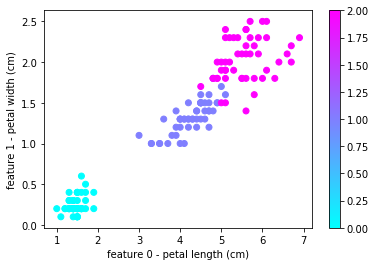

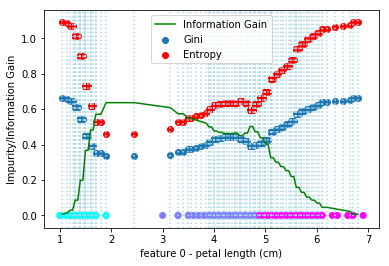

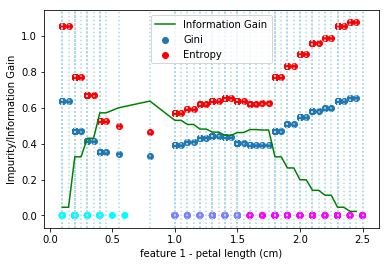

In [498]:
dataset = load_iris()
features, irisclass, cnames, fnames = dataset['data'][:,2:], dataset['target'], dataset['target_names'] , dataset['feature_names']
#M, N = X.shape
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
plt.scatter(features[:,0],features[:,1], c=irisclass, cmap=plt.cm.cool)
cb = plt.colorbar()
ax1.set_xlabel("feature 0 - " + fnames[2])
ax1.set_ylabel("feature 1 - " + fnames[3])

def calculateGini(p_class):
    pc = (p_class/np.sum(p_class,axis=0)).reshape(len(cnames),1)
    Gini = 1-pc.T.dot(pc)
    return Gini
def plotGiniEntr(feat_class, ix):
    N = len(feat_class)
    thresh = np.zeros((len(feat_class)-1,1))
    p_class_left = np.zeros((len(feat_class)-1,len(cnames)))
    p_class_right = np.zeros((len(feat_class)-1,len(cnames)))
    UGini = np.zeros((len(feat_class)-1,1))
    UEnt = np.zeros((len(feat_class)-1,1))
    IG = np.zeros((len(feat_class)-1,1))
    for i in range(len(feat_class)-1):
        th = (feat_class['f'].values[i+1] + feat_class['f'].values[i])/2
        thresh[i] = th
        left = feat_class.loc[feat_class['f'].values <= th]; L=len(left)
        right = feat_class.loc[feat_class['f'].values > th]; R=len(right)
        for j in range(len(cnames)):
            p_class_left[i][j] = len(left.loc[left['c'].values == j])
        for j in range(len(cnames)):
            p_class_right[i][j] = len(right.loc[right['c'].values == j])
        #Gini calculation
        GiniL = calculateGini(p_class_left[i])
        GiniR = calculateGini(p_class_right[i])
        UGini[i] = (L/N)*GiniL + (R/N)*GiniR
        #Entropy calculation
        EntL = sc.stats.entropy(p_class_left[i])
        EntR = sc.stats.entropy(p_class_right[i])
        UEnt[i] = (L/N)*EntL + (R/N)*EntR
        Ent = sc.stats.entropy(p_class_left[i] + p_class_right[i])
        IG[i] = Ent - UEnt[i]
    
    fig = plt.figure(figsize=(6,4))  
    ax2 = fig.add_subplot(111)
    ax2.cla()
    ax2.scatter(feat_class['f'], np.zeros((N,1)), c=irisclass, cmap=plt.cm.cool)
    for x in thresh:
        ax2.axvline(x, color='lightblue',ls=':')
    ax2.scatter(thresh, UGini, label='Gini')
    ax2.scatter(thresh, UEnt, color='red', label='Entropy')
    ax2.plot(thresh,IG, color='green', label='Information Gain')
    #ax2.set_ylim((-0.01,1.5))
    ax2.set_xlabel("feature " + str(ix) + " - " + fnames[2])
    ax2.set_ylabel("Impurity/Information Gain")
    ax2.legend()

f0_class = pd.DataFrame({'f':features[:,0],'c': irisclass }).sort_values(by=['f'], ascending=True)
plotGiniEntr(f0_class,0)
f1_class = pd.DataFrame({'f':features[:,1],'c': irisclass }).sort_values(by=['f'], ascending=True)
plotGiniEntr(f1_class,1)
    

# Question 4: ROC curve and the AUC score

Suppose you are given two probability distributions, each denoting a class conditional density of a feature.

Sample from the distributions and estimate the ROC curve and the AUC (area under the curve) score.

The densities should be 

1. Gaussians with mean $\mu_0$ and variance $V_0$ $\mathcal{N}(\mu_0, V_0)$ and $\mu_1$ and variance $V_1$
1. Symmetric triangular distribution on the inteval $(a_0, b_0)$ and $(a_1, b_1)$

Note that your code should work for any variance and mean value. 
Here are example plots for $\mathcal{N}(0,0.1)$ and $\mathcal{N}(1,0.5)$

![](img/normal.png)
![](img/ROC.png)

In [501]:
#def sample(m0,v0,m1,v1):

def plothist(s0,s1):
    fig = plt.figure(figsize=(6,4))
    h, bins, ignored = plt.hist(s0, 25, normed=True)
    width = (bins[1] - bins[0])
    normed_h = h/np.sum(h*width, axis=0)
    center = (bins[:-1] + bins[1:]) / 2
    plt.plot(bins, 1/(v0 * np.sqrt(2 * np.pi)) * np.exp( - (bins - m0)**2 / (2 * v0**2) ), linewidth=2, color='r')
    plt.bar(center, height = normed_h , align='center', width=width, color='green'  )
    
    h, bins, ignored = plt.hist(s1, 25, normed=True)
    width = (bins[1] - bins[0])
    normed_h = h/np.sum(h*width, axis=0)
    center = (bins[:-1] + bins[1:]) / 2
    plt.plot(bins, 1/(v1 * np.sqrt(2 * np.pi)) * np.exp( - (bins - m1)**2 / (2 * v1**2) ), linewidth=2, color='r')
    plt.bar(center, height = normed_h , align='center', width=width, color='darkblue' )
    plt.show() 

def estimateClass(val):
    posterior = np.zeros((3,1))
    likelihood1 = np.exp(-np.power(val-m0,2)/(2*v0))*(1/np.sqrt(2*np.pi*v0)) 
    likelihood2 = np.exp(-np.power(val-m1,2)/(2*v1))*(1/np.sqrt(2*np.pi*v1))
    prior1 = len(s1)/(len(s1)+len(s2))
    prior2 = 1 - prior1
    posterior[0] = (likelihood1*prior1)/(likelihood1*prior1+likelihood2*prior2)
    posterior[1] = (likelihood2*prior2)/(likelihood1*prior1+likelihood2*prior2)
    posterior[2] = val
    c = 0
    if posterior[1] == max(posterior[0], posterior[1]):
        c = 1
    return c, posterior

def plothistt(m0,v0,m1,v1):
    tp = 0; tn = 0; fp = 0; fn = 0
    c0 =  np.zeros((1000,1)) 
    c1 =  np.ones((1000,1)) 
    s0 = np.random.normal(m0, v0, 1000).reshape(1000,1)
    s1 = np.random.normal(m1, v1, 1000).reshape(1000,1)
    plothist(s0,s1)
    sample = pd.DataFrame(np.vstack((np.hstack((s0,c0)),np.hstack((s1,c1)))), columns=['data','trueclass']).sort_values(by=['data']).reset_index(drop=True)
    estimated = pd.DataFrame(np.zeros((len(sample),5)), columns=['estimatedclass','tp','tn','fp','fn'])
    for i in range(len(sample)):
        est, post = estimateClass(sample.values[i][0])
        if est == sample.values[i][1]:
            if est == 0:
                tn +=1
            else:
                tp +=1
        else:
            if est == 0:
                fn +=1
            else:
                fp +=1
        estimated.values[i][0] = est
        estimated.values[i][1] = tp
        estimated.values[i][2] = tn
        estimated.values[i][3] = fp
        estimated.values[i][4] = fn
        
    # 0thcol-data, 1-trueclass, 2-estimatedclass, 3-tpnum, 4-tnnum, 5-fpnum, 6-fnnum
    frames = [sample, estimated]
    data = pd.concat(frames, axis=1)
    fig = plt.figure(figsize=(7,5))
    ax1 = fig.add_subplot(111)
    fpr = np.divide(data['fp'],(data['fp']+data['tn']))
    tpr = np.divide(data['tp'],(data['tp']+data['fn']))
    fpr[np.isnan(fpr)] = 0
    tpr[np.isnan(tpr)] = 0
    ax1.plot(fpr,tpr)
    ax1.set_xlim((0,1));ax1.set_ylim((0,1))

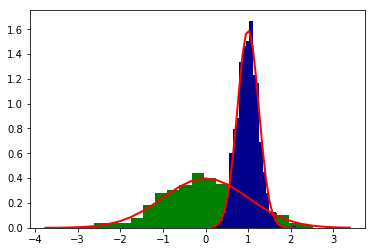

c:\users\sila\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


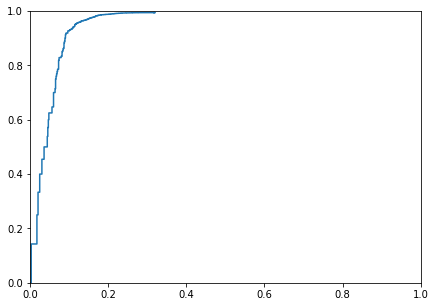

In [502]:
plothistt(0,1,1,0.25)